1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
Сделать выводы о зависимости ошибки от этих параметров.

In [158]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [159]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)

In [160]:
# Разделим выборку на обучающую и тестовую в соотношении 75/25.
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [161]:
# Функция, реализующую предсказание в градиентном бустинге.
# Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
# поэтому все деревья из списка trees_list уже являются дополнительными и 
# при предсказании прибавляются с шагом eta
def gb_predict(X, trees_list, coef_list, eta):
    res = np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])
    return res

In [162]:
# Функция среднеквадратичной ошибки
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [163]:
# Функция потерь
def bias(y, z):
    return (y - z)

In [164]:
# Обучение градиененого бустинга
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [172]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees, max_depth):
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    train_error = mean_squared_error(y_train, train_prediction)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {train_error}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    test_error = mean_squared_error(y_test, test_prediction)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {test_error}')
    print('*'*100)
    return train_error, test_error

In [173]:
def num_tree(number_of_trees, max_depth):
    eta = 0.1
    train_trees = {}
    test_trees = {}
    for i in range(1, number_of_trees+1):
        n_trees = i
        coefs = [1]*n_trees
        trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        all_errors = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees, max_depth)
        train_trees[i] = all_errors[0]
        test_trees[i] = all_errors[1]
    return train_trees, test_trees

In [175]:
train_trees, test_trees = num_tree(10, 3)

Ошибка алгоритма из 1 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 24145.92795497978
Ошибка алгоритма из 1 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 23835.886263241784
****************************************************************************************************
Ошибка алгоритма из 2 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 20055.193717364145
Ошибка алгоритма из 2 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 19841.752141131277
****************************************************************************************************
Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 16734.720679770882
Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 16599.819468689868
****************************************************************************************************
Ошибка алгоритма из 4 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 14035.62759

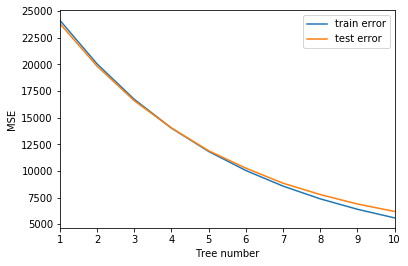

In [176]:
import matplotlib.pyplot as plt

plt.xlabel('Tree number')
plt.ylabel('MSE')
plt.xlim(1, len(all_trees))
plt.plot(list(train_trees.keys()), list(train_trees.values()), label='train error')
plt.plot(list(test_trees.keys()), list(test_trees.values()), label='test error')
plt.legend(loc='upper right')
plt.show()

Вывод: С увеличением количества деревьев ошибка тестовой выборки, по сравнению с тренировочным сетом, уменьшается до 4 - 5 деревьев, а затем растет.

In [177]:
def num_depth(n_trees, m_depth):
    eta = 0.1
    coefs = [1]*n_trees
    train_trees = {}
    test_trees = {}
    for i in range(1, m_depth+1):
        max_depth = i
        trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        all_errors = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees, max_depth)
        train_trees[i] = all_errors[0]
        test_trees[i] = all_errors[1]
    return train_trees, test_trees

In [179]:
train_trees, test_trees = num_depth(5, 10)

Ошибка алгоритма из 5 деревьев глубиной 1     с шагом 0.1 на тренировочной выборке: 12755.271881682454
Ошибка алгоритма из 5 деревьев глубиной 1     с шагом 0.1 на тестовой выборке: 12507.85315932985
****************************************************************************************************
Ошибка алгоритма из 5 деревьев глубиной 2     с шагом 0.1 на тренировочной выборке: 12171.992560919874
Ошибка алгоритма из 5 деревьев глубиной 2     с шагом 0.1 на тестовой выборке: 12108.200489895744
****************************************************************************************************
Ошибка алгоритма из 5 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 11844.326350318917
Ошибка алгоритма из 5 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 11907.924101380133
****************************************************************************************************
Ошибка алгоритма из 5 деревьев глубиной 4     с шагом 0.1 на тренировочной выборке: 11478.94900

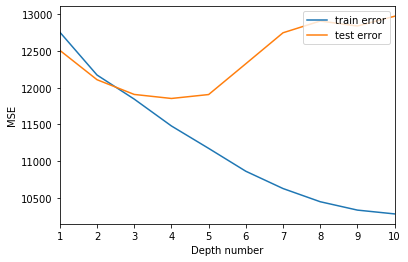

In [180]:
plt.xlabel('Depth number')
plt.ylabel('MSE')
plt.xlim(1, len(all_trees))
plt.plot(list(train_trees.keys()), list(train_trees.values()), label='train error')
plt.plot(list(test_trees.keys()), list(test_trees.values()), label='test error')
plt.legend(loc='upper right')
plt.show()

Ошибка тестовой выборки при увеличении глубины дерева уменьшается, по сравнению с тренировочным сетом, до 4, а затем растет.